In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [2]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [5]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
monitor_position =  1 / fcen * 2
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 0.5

Sx = tpml+width_bot_ag+tpml
Sy = round(tag_bot+tag_side+design_region_height+monitor_position+monitor_blank+tpml, 1)

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
# Ny = int(design_region_resolution * design_region_height) + 1
Ny = 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), TiO2, SiO2,  grid_type="U_MEAN")

boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [6]:
# 셀 크기 설정
cell_size = mp.Vector3(Sx, Sy)

# 기본 지오메트리 정의
geometry = [
    # Bottom Ag layer
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    # SiO2 layer
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    # Side metal
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]


In [43]:
# 몇개의 layer로 최적화를 할건지 설정하고 싶다면 layer_num 갯수 조절
layer_num = 1

ML = (layer_num > 1)

region_height_each = design_region_height / layer_num
full_center_y = y_bottom + tag_bot + tsio2 + design_region_height/2

if ML:
    design_variables = []
    design_region = []
    for dv in range(layer_num):
        mg = mp.MaterialGrid(
            mp.Vector3(Nx, Ny),
            TiO2,       
            SiO2,       
            grid_type="U_MEAN",
            do_averaging=False
        )
        design_variables.append(mg)
        offset = ((layer_num - 1) / 2 - dv) * region_height_each
        center_y = full_center_y + offset

        dr = mpa.DesignRegion(
            mg,
            volume=mp.Volume(
                center=mp.Vector3(0, center_y, 0),
                size=mp.Vector3(design_region_width, region_height_each, 0),
            ),
        )
        design_region.append(dr)

        geometry.append(
            mp.Block(
                material=design_variables[dv],
                size=design_region[dv].size,
                center=design_region[dv].center
            )
        )
else:
    design_variables = mp.MaterialGrid(
        mp.Vector3(Nx, Ny),
        TiO2,
        SiO2,
        grid_type="U_MEAN",
        do_averaging=False
    )
    design_region = mpa.DesignRegion(
        design_variables,
        volume=mp.Volume(
            center=mp.Vector3(0, full_center_y, 0),
            size=mp.Vector3(design_region_width, region_height_each, 0),
        )
    )
    geometry.append(
        mp.Block(
            material=design_variables,
            size=design_region.size,
            center=design_region.center
        )
    )


In [44]:
num_sources = 3
spacing = 10 / resolution  

# offsets = np.linspace(-width_sio2/2+spacing,
#                        width_sio2/2-spacing,
#                        num_sources)

offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ez,
        center=mp.Vector3(offset, center_y_source_position, 0)
    )
    for offset in offsets
]

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        extra_materials=[Ag]
    )
    for src in sources
]

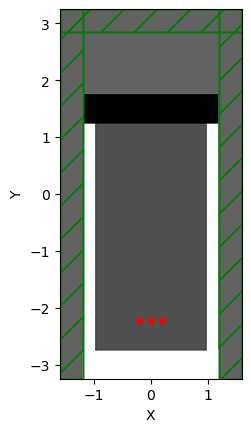

In [45]:
for i in range(num_sources):
    sims[i].plot2D()


🔄 Iteration 시작 전 초기화: Source 1
▶️ Running Simulation for Source 1
📊 Plotting 2D Ez for Source 1


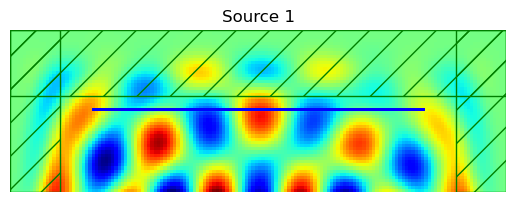

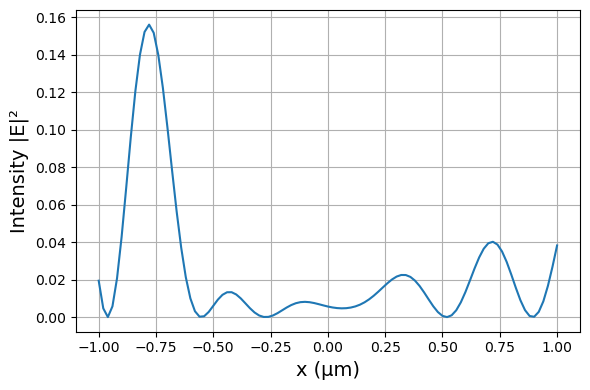


🔍 Source 1
  Input  flux : 0.147930
  Output flux : 0.086644
  EQE (%)     : 58.57 %

🔄 Iteration 시작 전 초기화: Source 2
▶️ Running Simulation for Source 2
📊 Plotting 2D Ez for Source 2


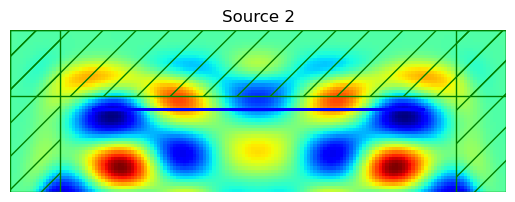

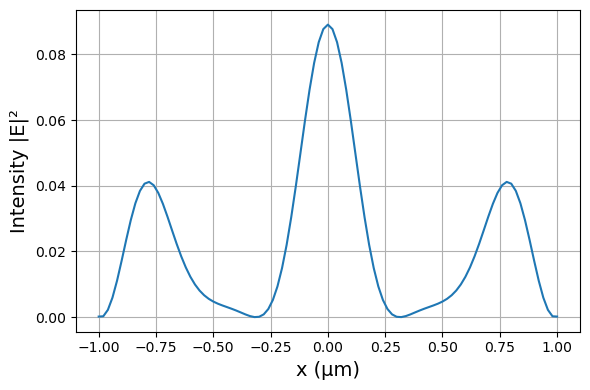


🔍 Source 2
  Input  flux : 0.139492
  Output flux : 0.055674
  EQE (%)     : 39.91 %

🔄 Iteration 시작 전 초기화: Source 3
▶️ Running Simulation for Source 3
📊 Plotting 2D Ez for Source 3


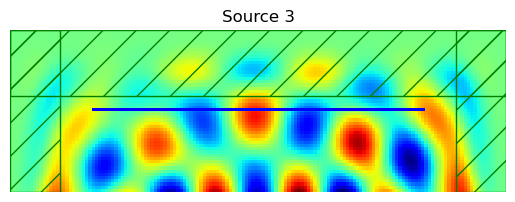

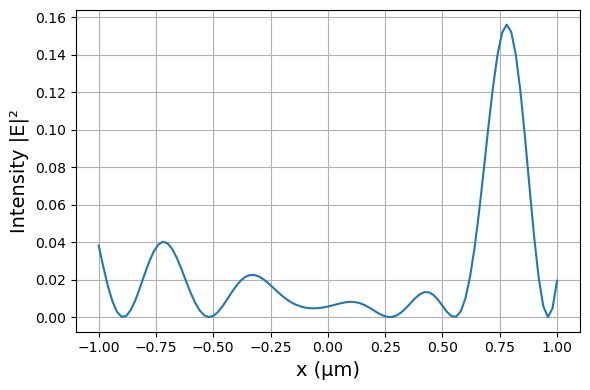


🔍 Source 3
  Input  flux : 0.147930
  Output flux : 0.086644
  EQE (%)     : 58.57 %

=== Summary EQE per source ===
Source 1: EQE = 58.57 %
Source 2: EQE = 39.91 %
Source 3: EQE = 58.57 %


In [46]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# verbosity off
mp.verbosity(0)

# parameters
offset    = 0.01
flux_size = 0.02
mn_size   = 2

monitor_position_y = mp.Vector3(0, center_y_monitor_position)
monitor_size       = mp.Vector3(mn_size, 0)

# prepare storage
input_flux_list  = []
output_flux_list = []
dft_fields_list  = []
eqe_list         = []

# loop over sims & sources
for i, (sim, src) in enumerate(zip(sims, sources), start=1):
    print(f"\n🔄 Iteration 시작 전 초기화: Source {i}")
    sim.reset_meep()

    # add input flux monitor around the dipole
    input_flux = sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=src.center - mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size), weight=-1),
        mp.FluxRegion(center=src.center + mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size)),
        mp.FluxRegion(center=src.center - mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0), weight=-1),
        mp.FluxRegion(center=src.center + mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0))
    )
    input_flux_list.append(input_flux)

    # add output flux monitor at the planar monitor position
    output_flux = sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=monitor_position_y,
                      size=monitor_size)
    )
    output_flux_list.append(output_flux)

    # add DFT field monitor
    dft_fields = sim.add_dft_fields(
        [mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz],
        fcen, 0, 1,
        center=monitor_position_y,
        size=monitor_size,
        yee_grid=True
    )
    dft_fields_list.append(dft_fields)

    # run until fields decayed
    print(f"▶️ Running Simulation for Source {i}")
    sim.run(
        until_after_sources=mp.stop_when_fields_decayed(
            10/df, mp.Ez, src.center, 1e-5
        )
    )

    # spatial plot of Ez
    print(f"📊 Plotting 2D Ez for Source {i}")
    sim.plot2D(
        fields=mp.Ez,
        output_plane=mp.Volume(center=monitor_position_y,
                               size=mp.Vector3(3,1)),
        field_parameters={'post_process': lambda x: np.real(x),
                          'cmap': 'jet', 'alpha': 1,
                          'interpolation': 'none'},
        eps_parameters={'cmap':'magma','alpha':0.8}
    )
    plt.axis(False)
    plt.title(f"Source {i}", fontsize=12)
    plt.show()

    # 1D intensity profile from DFT
    E_line = np.real(sim.get_dft_array(dft_fields, mp.Ez, 0))
    x = np.linspace(-mn_size/2, mn_size/2, E_line.size)
    I = np.abs(E_line)**2

    plt.figure(figsize=(6,4))
    plt.plot(x, I, label=f"Source {i}")
    plt.xlabel('x (µm)', fontsize=14)
    plt.ylabel('Intensity |E|²', fontsize=14)
    # plt.title(f"Source {i} – Monitor size: {mn_size}µm", fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # compute EQE
    Pin  = mp.get_fluxes(input_flux)[0]
    Pout = mp.get_fluxes(output_flux)[0]
    eqe  = 100 * Pout/Pin
    eqe_list.append(eqe)

    print(f"\n🔍 Source {i}")
    print(f"  Input  flux : {Pin:.6f}")
    print(f"  Output flux : {Pout:.6f}")
    print(f"  EQE (%)     : {eqe:.2f} %")

# print summary
print("\n=== Summary EQE per source ===")
for i, val in enumerate(eqe_list, start=1):
    print(f"Source {i}: EQE = {val:.2f} %")


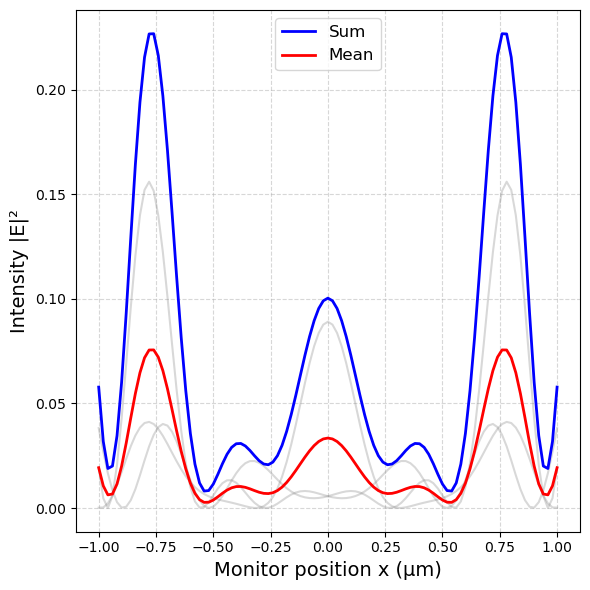

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# === 0) I_profiles 수집용 리스트 초기화 ===
I_profiles = []

# === 1) 각 sim에서 1D intensity 프로파일 계산 & 저장 ===
for sim, dft in zip(sims, dft_fields_list):
    # (이미 sim.run(...) 이 완료된 상태여야 합니다)
    E_line = np.real(sim.get_dft_array(dft, mp.Ez, 0))  # 1D 배열 
    I = np.abs(E_line)**2                              # intensity
    I_profiles.append(I)

# === 2) x 좌표 벡터 생성 ===
N = I_profiles[0].size
x = np.linspace(-mn_size/2, mn_size/2, N)

# === 3) 합(sum) 및 평균(mean) 프로파일 계산 ===
I_stack = np.vstack(I_profiles)   # shape = (num_sources, N)
I_sum   = I_stack.sum(axis=0)     # 각 x 위치별 합
I_mean  = I_stack.mean(axis=0)    # 각 x 위치별 평균

# === 4) 한 그래프에 개별·합·평균 모두 그리기 ===
plt.figure(figsize=(6,6))

# (가) 개별 소스 프로파일: 연회색 얇은 선
for I in I_profiles:
    plt.plot(x, I, color='gray', alpha=0.3)

# (나) 합 프로파일: 검정 두꺼운 선
plt.plot(x, I_sum, 'b-', lw=2, label='Sum')

# (다) 평균 프로파일: 빨강 두꺼운 선
plt.plot(x, I_mean, 'r-', lw=2, label='Mean')

plt.xlabel('Monitor position x (µm)', fontsize=14)
plt.ylabel('Intensity |E|²', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


적분 범위: ±0.260 µm → P_total(1차 링까지) = 0.031004


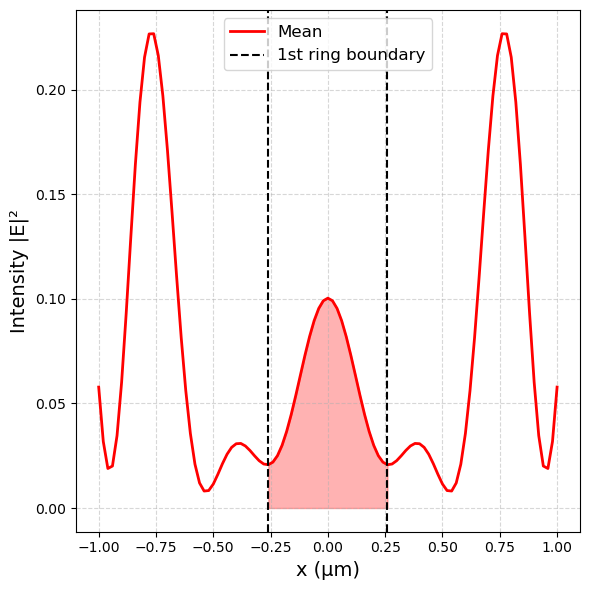

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# --- 0) I_profiles & x, I_mean 계산 (생략 가능) ---
I_profiles = []
for sim, dft in zip(sims, dft_fields_list):
    Ez_line = np.real(sim.get_dft_array(dft, mp.Ez, 0))
    I_profiles.append(np.abs(Ez_line)**2)

N       = I_profiles[0].size
x       = np.linspace(-mn_size/2, mn_size/2, N)
I_stack = np.vstack(I_profiles)
I_mean = I_stack.mean(axis=0)

# --- 1) "진짜 중앙" 피크 찾기 ---
peaks, _ = find_peaks(I_mean)
if len(peaks)==0:
    center_idx = np.argmax(I_mean)
else:
    center_idx = peaks[np.argmin(np.abs(x[peaks]))]

# --- 2) 중앙 이후 첫 번째 · 두 번째 국소 최소점 검출 ---
minima_idx = []
for j in range(center_idx+1, N-1):
    if I_mean[j] < I_mean[j-1] and I_mean[j] < I_mean[j+1]:
        minima_idx.append(j)
        if len(minima_idx) >= 2:
            break

ring1_idx = minima_idx[0] if len(minima_idx)>0 else None
# ring2_idx = minima_idx[1] if len(minima_idx)>1 else None  # 더 이상 사용 안 함

x_ring1 = abs(x[ring1_idx]) if ring1_idx is not None else mn_size/2
# x_ring2 = abs(x[ring2_idx]) if ring2_idx is not None else mn_size/2

# --- 3) 적분 범위를 1차 링까지로 한정 ---
mask_total = (np.abs(x) <= x_ring1)   # <-- 2차 대신 1차 링까지
P_total    = np.trapz(I_mean[mask_total], x[mask_total])

# (원한다면 1차 링 내 세기도 별도 계산)
mask1 = mask_total
P1     = P_total
eff1   = 100.0  # P1 / P_total * 100 이므로 항상 100%

# --- 4) 결과 출력 ---
print(f"적분 범위: ±{x_ring1:.3f} µm → P_total(1차 링까지) = {P_total:.6f}")
# print(f"1차 링 내 세기 P1 = {P1:.6f}, 효율 = {eff1:.2f}%")

# --- 5) 시각화 ---
plt.figure(figsize=(6,6))
plt.plot(x, I_mean, 'r-', lw=2, label='Mean')
plt.axvline(-x_ring1, ls='--', color='k', label='1st ring boundary')
plt.axvline(+x_ring1, ls='--', color='k')

plt.fill_between(x, I_mean, where=mask_total,
                 interpolate=True,
                 color='red', alpha=0.3)

plt.xlabel('x (µm)', fontsize=14)
plt.ylabel('Intensity |E|²', fontsize=14)
plt.legend(fontsize=12)
plt.grid(ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [91]:
0.031004/0.145117*100

21.364829758057294

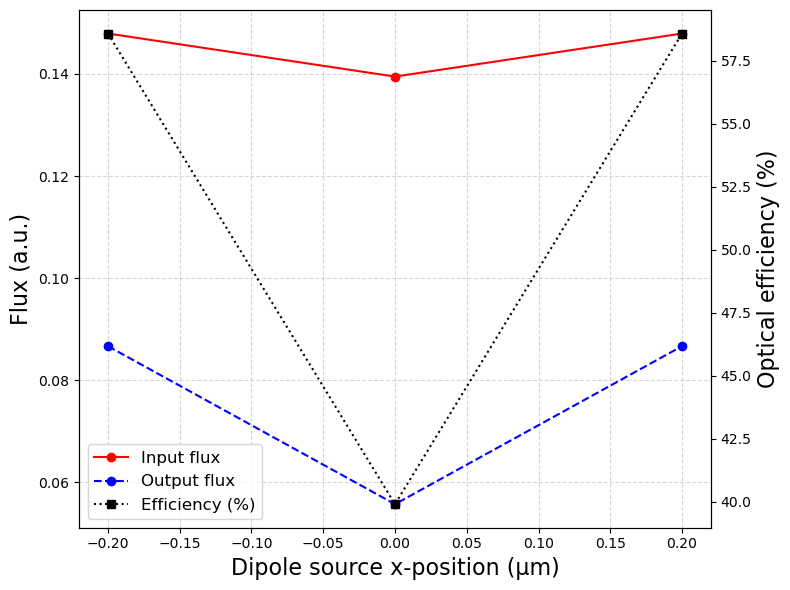

In [80]:
positions      = [src.center.x for src in sources]
input_values   = [mp.get_fluxes(f)[0] for f in input_flux_list]
output_values  = [mp.get_fluxes(f)[0] for f in output_flux_list]
percent_values = [100 * outv / inv if inv != 0 else 0
                  for inv, outv in zip(input_values, output_values)]

fig, ax1 = plt.subplots(figsize=(8,6))

# 왼쪽 축에 입력/출력 flux
ax1.plot(positions, input_values,  'ro-', label='Input flux')
ax1.plot(positions, output_values, 'bo--', label='Output flux')
ax1.set_xlabel('Dipole source x-position (µm)', fontsize=16)
ax1.set_ylabel('Flux (a.u.)',              fontsize=16, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='both', ls='--', alpha=0.5)

# 오른쪽 축에 효율
ax2 = ax1.twinx()
ax2.plot(positions, percent_values, 'ks:', label='Efficiency (%)')
ax2.set_ylabel('Optical efficiency (%)', fontsize=16, color='k')
ax2.tick_params(axis='y', labelcolor='k')

# 범례 합치기
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=12)

plt.tight_layout()
plt.show()


In [85]:
import numpy as np

# Assuming x, I_sum, I_mean are already defined in the environment
# Stack into columns: x, sum, mean
data = np.vstack([x, I_sum, I_mean]).T

# Save to text file
file_path = '/home/min/EIDL/Tool/Meep/LGD/LGD setup/Mode decomposition/Kyungmin/2025/07/22/Postprocess/combined_intensity.txt'
np.savetxt(file_path, data, header='x I_sum I_mean', fmt='%.6e')

print(f"Saved combined intensity data to: {file_path}")


Saved combined intensity data to: /home/min/EIDL/Tool/Meep/LGD/LGD setup/Mode decomposition/Kyungmin/2025/07/22/Postprocess/combined_intensity.txt



🔄 Iteration 시작 전 초기화: Source 1
▶️ Running Simulation for Source 1
📊 Plotting Result for Source 1


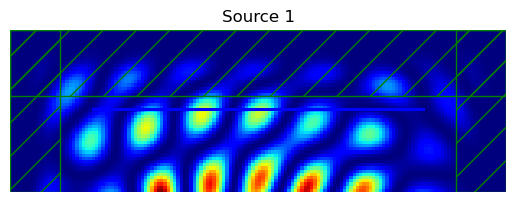

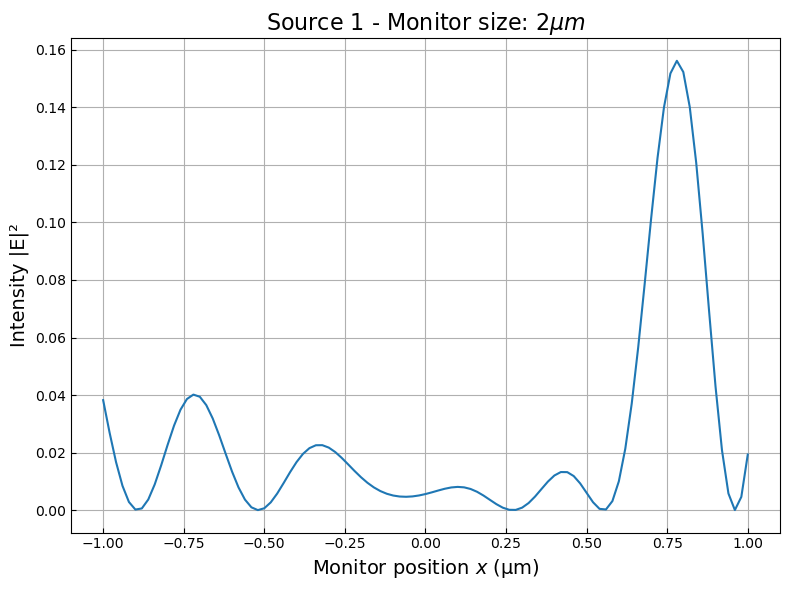


🔍 Source 1
Input flux  : 0.000033
Output flux : 0.086705
EQE (%)     : 266524.24 %


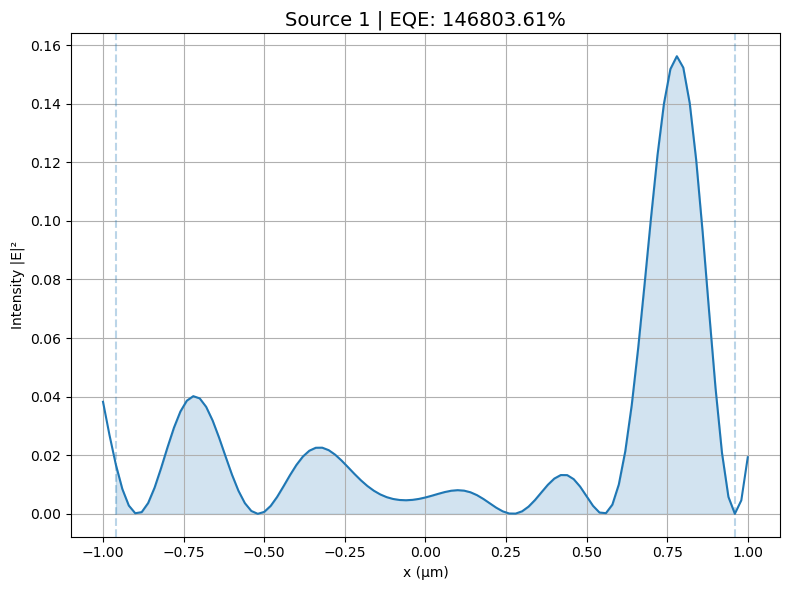


🔄 Iteration 시작 전 초기화: Source 2
▶️ Running Simulation for Source 2
📊 Plotting Result for Source 2


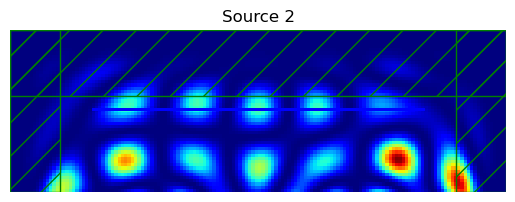

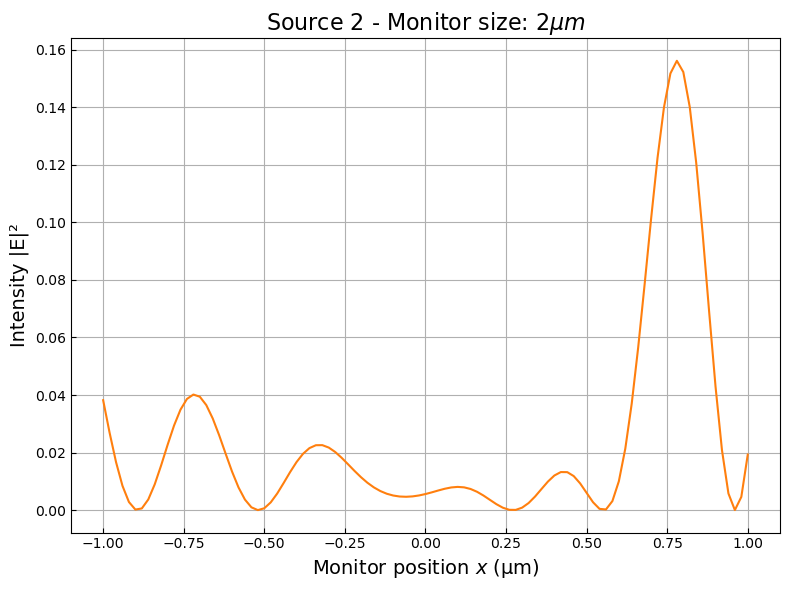


🔍 Source 2
Input flux  : 0.000008
Output flux : 0.086672
EQE (%)     : 1149732.01 %


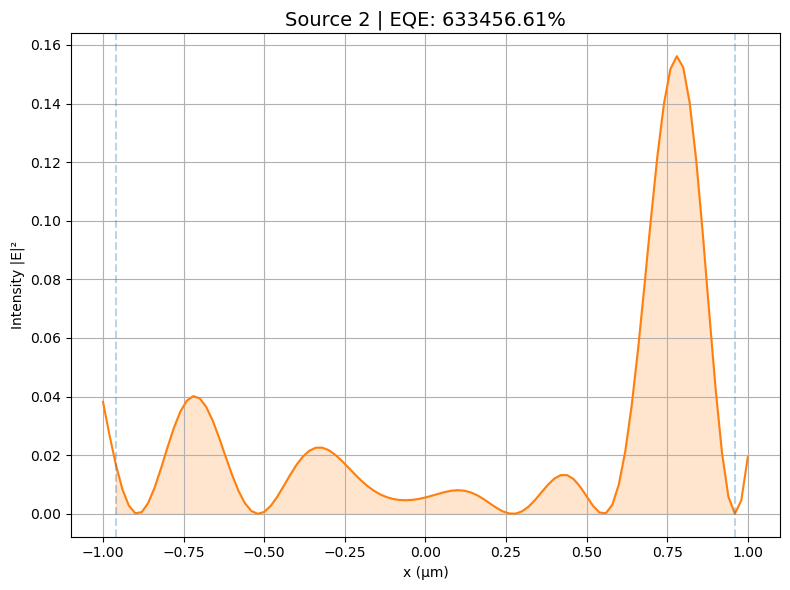


🔄 Iteration 시작 전 초기화: Source 3
▶️ Running Simulation for Source 3
📊 Plotting Result for Source 3


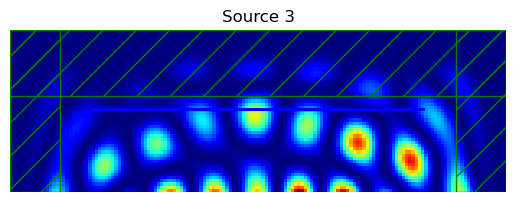

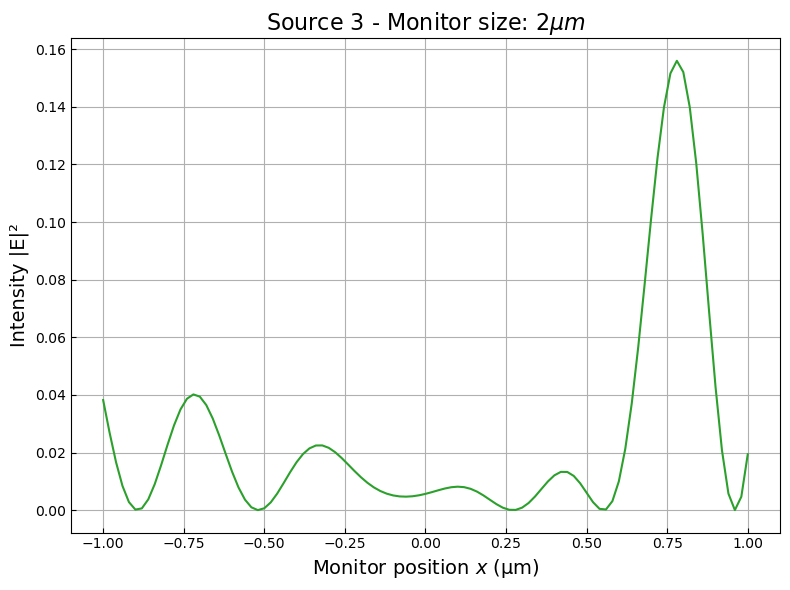


🔍 Source 3
Input flux  : 0.147930
Output flux : 0.086644
EQE (%)     : 58.57 %


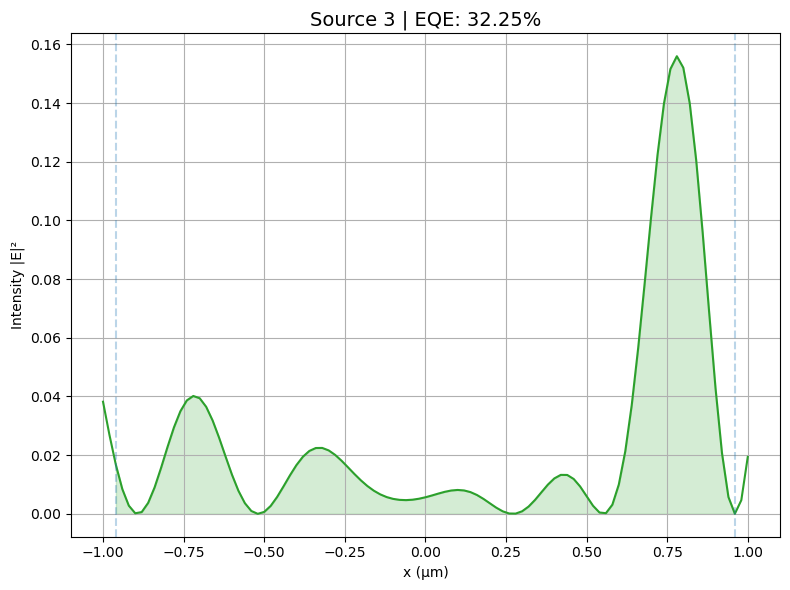

Source 1 → EQE: 266524.24 %
Source 2 → EQE: 146803.61 %
Source 3 → EQE: 1149732.01 %
Source 4 → EQE: 633456.61 %
Source 5 → EQE: 58.57 %
Source 6 → EQE: 32.25 %


In [39]:
mp.verbosity(0)
eqe_list = []
input_flux_list = []
out_flux_list = []

for i in range(num_sources):
    print(f"\n🔄 Iteration 시작 전 초기화: Source {i+1}")
    sim.reset_meep()
    mp.verbosity(0)
    
    input_flux = sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=sources[i].center - mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size), weight=-1),
        mp.FluxRegion(center=sources[i].center + mp.Vector3(offset, 0, 0),
                      size=mp.Vector3(0, flux_size)),
        mp.FluxRegion(center=sources[i].center - mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0), weight=-1),
        mp.FluxRegion(center=sources[i].center + mp.Vector3(0, offset, 0),
                      size=mp.Vector3(flux_size, 0))
    )
    input_flux_list.append(input_flux)  

    out_flux = sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
            center=monitor_position_y,
            size=monitor_size
        )
    )
    out_flux_list.append(out_flux)  

    dft_fields = sim.add_dft_fields(
        [mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz],
        fcen, 0, 1,
        center=monitor_position_y,
        size=monitor_size,
        yee_grid=True
    )
    dft_fields_list[i] = dft_fields

    print(f"▶️ Running Simulation for Source {i+1}")
    sim.run(
        until_after_sources=mp.stop_when_fields_decayed(
            10 / df, mp.Ez, sources[i].center, 1e-5
        )
        # until = 300
    )

    print(f"📊 Plotting Result for Source {i+1}")
    sim.plot2D(
        fields=mp.Ez,
        output_plane=mp.Volume(center=monitor_position_y, size=mp.Vector3(3, 1)),
        field_parameters={'post_process': lambda x: np.real(x)**2, 'cmap': 'jet', 'alpha': 1, 'interpolation': 'none'},
        eps_parameters={'cmap': 'jet', 'alpha': 0.8}
    )
    plt.axis(False)
    plt.title(f"Source {i+1}", fontsize=12)
    plt.show()

    # DFT 필드 intensity 플롯
    external_field_array = np.real(sim.get_dft_array(dft_fields, mp.Ez, 0))
    N = len(external_field_array)
    x = np.linspace(-mn_size / 2, mn_size / 2, N)
    I = np.abs(external_field_array)**2

    plt.figure(figsize=(8, 6))
    plt.plot(x, I, label=f"Source {i+1}", color=f"C{i}")
    plt.xlabel('Monitor position $x$ (µm)', fontsize=14)
    plt.ylabel('Intensity |E|²', fontsize=14)
    plt.title(rf'Source {i+1} - Monitor size: ${mn_size}\mu m$', fontsize=16)
    plt.tick_params(direction='in')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ✅ EQE 계산
    input_power = mp.get_fluxes(input_flux)[0]
    output_power = mp.get_fluxes(out_flux)[0]
    eqe = (output_power / input_power) * 100
    eqe_list.append(eqe)

    print(f"\n🔍 Source {i+1}")
    print(f"Input flux  : {input_power:.6f}")
    print(f"Output flux : {output_power:.6f}")
    print(f"EQE (%)     : {eqe:.2f} %")

    E = np.real(sim.get_dft_array(dft_fields_list[i], mp.Ez, 0))
    I = np.abs(E)**2
    N = len(I)
    x = np.linspace(-mn_size/2, mn_size/2, N)
    dx = x[1] - x[0]

    # 중심 피크 기준 첫 번째 링까지의 적분
    center_idx = np.argmax(I)
    for j in range(center_idx+1, N-1):
        if I[j] < I[j-1] and I[j] < I[j+1]:
            x_limit = abs(x[j])
            break
    else:
        x_limit = mn_size / 2

    mask = (x >= -x_limit) & (x <= x_limit)
    output_power = np.sum(I[mask]) * dx
    input_power = mp.get_fluxes(input_flux)[0]
    eqe = (output_power / input_power) * 100
    eqe_list.append(eqe)

    # 시각화
    plt.figure(figsize=(8, 6))
    plt.plot(x, I, label=f"Source {i+1}", color=f"C{i}")
    plt.axvline(-x_limit, linestyle="--", alpha=0.3)
    plt.axvline(x_limit, linestyle="--", alpha=0.3)
    plt.fill_between(x, I, where=mask, color=f"C{i}", alpha=0.2)
    plt.title(f"Source {i+1} | EQE: {eqe:.2f}%", fontsize=14)
    plt.xlabel("x (µm)")
    plt.ylabel("Intensity |E|²")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === 결과 출력 ===
for i, eqe in enumerate(eqe_list):
    print(f"Source {i+1} → EQE: {eqe:.2f} %")
    


In [36]:
# === dipole 위치별 input/output flux 출력 & 플롯 ===

# 1) 소스의 y 위치 리스트
positions = [src.center.x for src in sources]

# 2) flux 값 추출
input_values  = [mp.get_fluxes(f)[0] for f in input_flux_list]
output_values = [mp.get_fluxes(f)[0] for f in out_flux_list]

# 3) 테이블 형태로 출력
print("\nSource 위치별 Input/Output flux")
print("-" * 40)
for y, inp, out in zip(positions, input_values, output_values):
    print(f"y = {y:.3f} µm  |  Input flux = {inp:.6f}  |  Output flux = {out:.6f}")

# 4) 한 그래프에 플롯
plt.figure(figsize=(8,6))
plt.plot(positions, input_values,  'r-', label='Input flux')
plt.plot(positions, output_values, 'b--', label='Output flux')
plt.xlabel('Dipole source x-position (µm)', fontsize=16)
plt.ylabel('Flux (a.u.)', fontsize=16)
plt.title('After optimization', fontsize=16)
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

percent_values = [100 * outv / inv if inv != 0 else 0
                  for inv, outv in zip(input_values, output_values)]

print("\nSource 위치별 Output/Input 비율 (%)")
print("-" * 40)
for y, pct in zip(positions, percent_values):
    print(f"y = {y:.3f} µm  |  Output/Input = {pct:.2f} %")

plt.figure(figsize=(8,6))
plt.plot(positions, percent_values, '-', color='C2', label='Output/Input (%)')
plt.xlabel('Dipole source x-position (µm)', fontsize=16)
plt.ylabel('Optical efficiency (%)', fontsize=16)
plt.title('After optimization', fontsize=16)
plt.grid(True, ls='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


NameError: name 'out_flux_list' is not defined